In [33]:
import librosa, numpy as np, scipy, matplotlib, sklearn, pandas as pd

In [34]:
from gtts import gTTS
import os

transcripts = pd.read_csv('./real/transcripts/transcripts.csv')
transcripts.head(10)

,id,text
0,common_voice_en_40865211.mp3,"With this transition to the big time, the band..."
1,common_voice_en_40865212.mp3,Local brothels recruited extra staff to cope w...
2,common_voice_en_40865213.mp3,"With Fox on lead vocals, the threesome did two..."
3,common_voice_en_40865214.mp3,Miramax requested cuts be made and Christopher...
4,common_voice_en_40865215.mp3,The Key allows customers to buy Plusbus for th...
5,common_voice_en_40865221.mp3,"In this position he learnt mathematics, Greek,..."
6,common_voice_en_40865222.mp3,My books and my stories.
7,common_voice_en_40865223.mp3,They followed the streetcar lines to areas sou...
8,common_voice_en_40865224.mp3,She herself defended her verse as holy erotica.
9,common_voice_en_40865225.mp3,In the pamphlet What is to be Done?


Let's transform the wav to mp3 since wav is lossless

In [35]:
from pydub import AudioSegment

input_dir = "./real/original_audio"
output_dir = "./real/audio"
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(output_dir):
    if file.endswith('.wav'):
        os.remove(os.path.join(output_dir, file))
        
for fname in os.listdir(input_dir):
    if fname.endswith(".mp3"):
        mp3_path = os.path.join(input_dir, fname)
        wav_path = os.path.join(output_dir, fname.replace(".mp3", ".wav"))
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")

In [36]:
output_dir = './fake/audio'
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(output_dir):
    if file.endswith('.wav'):
        os.remove(os.path.join(output_dir, file))

for index, row in transcripts.iterrows():
    text = row['text']
    id = row['id']
    tts = gTTS(text=text, lang='en')
    filename = f"{id}_fake.wav"
    tts.save(os.path.join(output_dir, filename))

print(f'{len(transcripts)} audio files saved in {output_dir}')

60 audio files saved in ./fake/audio


In [55]:
real_dir = './real/audio'
fake_dir = './fake/audio'

data = []

for fname in os.listdir(real_dir):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(real_dir, fname), "label": "real"})

for fname in os.listdir(fake_dir):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(fake_dir, fname), "label": "fake"})

labeled_data = pd.DataFrame(data)
labeled_data.head()





,file,label
0,./real/audio/common_voice_en_40865223.wav,real
1,./real/audio/common_voice_en_40865222.wav,real
2,./real/audio/common_voice_en_40865221.wav,real
3,./real/audio/common_voice_en_40865225.wav,real
4,./real/audio/common_voice_en_40865224.wav,real


**Definition**: MFCCs represent the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. They aim to mimic the way humans perceive sound, especially how we’re more sensitive to certain frequency ranges (like speech).


In [56]:
def extract_mfcc(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

labeled_data["features"] = labeled_data["file"].apply(extract_mfcc)

In [57]:
labeled_data.head()

,file,label,features
0,./real/audio/common_voice_en_40865223.wav,real,"[-449.27832, 118.24586, 9.201565, -13.953555, ..."
1,./real/audio/common_voice_en_40865222.wav,real,"[-462.9273, 79.29145, -0.20513293, -0.6315125,..."
2,./real/audio/common_voice_en_40865221.wav,real,"[-443.14944, 121.675804, 2.2551014, 5.425762, ..."
3,./real/audio/common_voice_en_40865225.wav,real,"[-502.19363, 117.22501, 9.464894, -5.7915406, ..."
4,./real/audio/common_voice_en_40865224.wav,real,"[-445.36395, 109.39663, 3.058637, -3.7816339, ..."


In [58]:
from sklearn.model_selection import train_test_split

X = np.stack(labeled_data["features"].values)
y = labeled_data["label"].map({"real": 0, "fake": 1}).values  

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [59]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [60]:
print("Train labels:", pd.Series(y_train).value_counts())
print("Test labels:", pd.Series(y_test).value_counts())

Train labels: 0    48
1    47
dtype: int64
Test labels: 1    12
0    12
dtype: int64


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



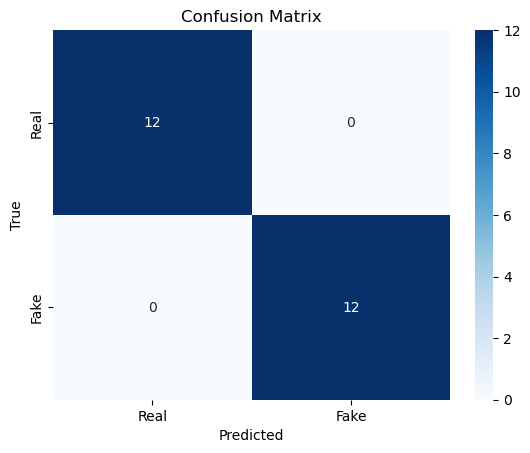

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

This are not good numbers for generalization. Maybe adding more samples will help out

In [63]:
print(pd.Series(y_test).value_counts())

1    12
0    12
dtype: int64


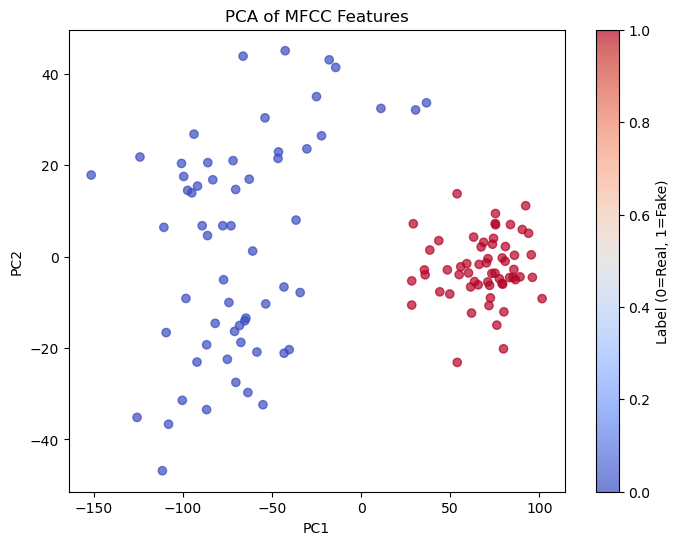

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.stack(labeled_data["features"].values)
y = labeled_data["label"].map({"real": 0, "fake": 1}).values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("PCA of MFCC Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Label (0=Real, 1=Fake)')
plt.show()

In [65]:
def get_duration(path):
    y, sr = librosa.load(path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

labeled_data["duration"] = labeled_data["file"].apply(get_duration)
labeled_data.groupby("label")["duration"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,59.0,4.744271,1.413869,2.328,3.780,4.872,5.424,10.896
real,60.0,6.698400,2.002080,3.204,5.382,6.120,8.289,11.520
